In [1]:
%load_ext autoreload
%autoreload 2

# Process raw wikipedia subset data
This notebook processes the raw wikipedia subset data and extracts the labelled entities and relations, which are then stored in a knowledge graph.

In [2]:
import spacy
import math

import preprocessor
from preprocessor import Preprocessor

# make the factory work
from rel_model.scripts.rel_pipe import make_relation_extractor

# make the config work
from rel_model.scripts.rel_model import create_relation_model, create_classification_layer, create_instances, create_tensors

from tqdm import tqdm

# Determine which assignment component to run
COMPONENT: int = 1 # 1 or 2
COMPONENT_1_SUBSET: str = "titles" # pages or titles

ROOT_DIR = preprocessor.ROOT_DIR
DATA_PATH = preprocessor.DATA_PATH

preprocessor = Preprocessor(ROOT_DIR)

c:\Users\Beheerder\AppData\Local\Programs\Python\Python310\lib\site-packages\spacy\util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.6.0) was trained with spaCy v3.6.0 and may not be 100% compatible with the current version (3.7.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


## 1. Load dataset and model
### 1.1 Load dataset based on component
Load the dataset based on which component is selected. If component 1 is selected, load the Wikipedia subset based on the variable `COMPONENT_1_SUBSET`.

In [3]:
# Define all component specific paths
if COMPONENT == 1:
    if COMPONENT_1_SUBSET == "titles":
        data = preprocessor.loadFile(f"unesco_wikipedia_titles.json")
    else:
        data = preprocessor.loadFile(f"unesco_wikipedia_pages.json")
        
    dataset = [article['text'] for article in data]
else:
    with open(f"{DATA_PATH}/part_2\\initiating-events-summary-2021.txt", "r", encoding="utf-8") as f:
        dataset = f.readlines()

### 1.2 Load best NER and REL models from training
Load the trained models using spacy in two separate `nlp_...` objects.

In [4]:
options = {
    "colors": {"location": "lightyellow",
               "person_name": "lightgreen",
               "landmark_name": "lightred",
               "condition": "lightblue"}
}

# Now test teh newly created spacy model on a sample text and visualize it using spacy
ner_model_path = f"ner_model/training_{COMPONENT}/model-best/"
rel_model_path = f"rel_model/training_{COMPONENT}/model-best/"
nlp_ner = spacy.load(ner_model_path)
nlp_rel = spacy.load(rel_model_path)

## 2. Extract entities and relations
### 2.1 Loop over texts and process with NER and REL models
Loop over all texts in the dataset and process them with the NLP models. Convert the resulting entities and relations to a format that is easily insertable in a Knowledge Graph.

In [5]:
# Threshold for probability filtering of relations
rel_threshold = 0.1

NER_ENTS = []
REL_TRIPLETS = []

for i, text in enumerate(tqdm(dataset)):   
    # NER
    doc_ner = nlp_ner(text)

    for j, ent in enumerate(doc_ner.ents):
        id = str("article_" + str(i) + "_ent_" + str(j))
        overview = {"id" : id, "type" : "labels", "value" : {"end" : ent.end_char, "text" : ent.text, "start" : ent.start_char, "labels" : [ent.label_]}}
        NER_ENTS.append(overview)
        
    # REL
    doc_rel = nlp_rel(doc_ner)
    
    relevant_relations = {}
    for rel in doc_rel._.rel:
        # Sort relationships by probability
        sorted_data = {k: v for k, v in sorted(doc_rel._.rel[rel].items(), key=lambda item: item[1])}
        
        # Filter out keys with values below the threshold
        filtered_data = {k: v for k, v in sorted_data.items() if v >= rel_threshold}

        # Get the first key from the filtered dictionary
        if filtered_data:
            first_key = next(iter(filtered_data))
            relevant_relations[rel] = first_key
        else:
            first_key = None
            
    # Create a dictionary mapping start_char to item names
    starting_char_to_name = {ent.start: ent.text for ent in doc_rel.ents}

    # List to store the triplets
    triplets = []

    # Iterate through the dictionary
    for key_tuple, value in relevant_relations.items():
        key_tuple_1, key_tuple_2 = key_tuple
        name_1 = starting_char_to_name.get(key_tuple_1, "")
        name_2 = starting_char_to_name.get(key_tuple_2, "")
        REL_TRIPLETS.append((name_1, name_2, value))
        
print("Total NER_ENTS: ", len(NER_ENTS))
print("Average NER_ENTS per article: ", math.ceil(len(NER_ENTS)/len(data)))
print("Total REL_TRIPLETS: ", len(REL_TRIPLETS))
print("Average REL_TRIPLETS per article: ", math.ceil(len(REL_TRIPLETS)/len(data)))
    

  1%|          | 2/373 [00:03<10:11,  1.65s/it]

ℹ Could not determine any instances in doc - returning doc as is.


  1%|          | 3/373 [00:04<07:27,  1.21s/it]

ℹ Could not determine any instances in doc - returning doc as is.


  1%|          | 4/373 [00:04<05:36,  1.10it/s]

ℹ Could not determine any instances in doc - returning doc as is.


  2%|▏         | 6/373 [00:07<07:28,  1.22s/it]

ℹ Could not determine any instances in doc - returning doc as is.


  3%|▎         | 11/373 [00:14<09:05,  1.51s/it]

ℹ Could not determine any instances in doc - returning doc as is.


  4%|▍         | 14/373 [00:16<05:41,  1.05it/s]

ℹ Could not determine any instances in doc - returning doc as is.


  5%|▍         | 17/373 [00:20<06:15,  1.05s/it]

ℹ Could not determine any instances in doc - returning doc as is.


  5%|▍         | 18/373 [00:20<05:36,  1.05it/s]

ℹ Could not determine any instances in doc - returning doc as is.


  5%|▌         | 20/373 [00:21<03:22,  1.74it/s]

ℹ Could not determine any instances in doc - returning doc as is.


  7%|▋         | 25/373 [00:26<05:09,  1.12it/s]

ℹ Could not determine any instances in doc - returning doc as is.


  7%|▋         | 27/373 [00:27<04:42,  1.23it/s]

ℹ Could not determine any instances in doc - returning doc as is.


  8%|▊         | 28/373 [00:28<04:51,  1.18it/s]

ℹ Could not determine any instances in doc - returning doc as is.


  9%|▉         | 35/373 [00:32<03:03,  1.84it/s]

ℹ Could not determine any instances in doc - returning doc as is.


 10%|▉         | 36/373 [00:33<03:13,  1.75it/s]

ℹ Could not determine any instances in doc - returning doc as is.


 10%|▉         | 37/373 [00:33<02:40,  2.09it/s]

ℹ Could not determine any instances in doc - returning doc as is.


 10%|█         | 38/373 [00:33<02:27,  2.27it/s]

ℹ Could not determine any instances in doc - returning doc as is.


 11%|█▏        | 42/373 [00:36<03:36,  1.53it/s]

ℹ Could not determine any instances in doc - returning doc as is.


 12%|█▏        | 46/373 [00:37<02:05,  2.60it/s]

ℹ Could not determine any instances in doc - returning doc as is.


 15%|█▌        | 56/373 [00:44<03:13,  1.64it/s]

ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.


 16%|█▌        | 58/373 [00:45<02:09,  2.42it/s]

ℹ Could not determine any instances in doc - returning doc as is.


 16%|█▌        | 60/373 [00:46<02:18,  2.26it/s]

ℹ Could not determine any instances in doc - returning doc as is.


 17%|█▋        | 62/373 [00:47<02:31,  2.05it/s]

ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.


 17%|█▋        | 63/373 [00:47<02:39,  1.94it/s]

ℹ Could not determine any instances in doc - returning doc as is.


 18%|█▊        | 68/373 [00:51<02:38,  1.92it/s]

ℹ Could not determine any instances in doc - returning doc as is.


 19%|█▉        | 72/373 [00:53<02:57,  1.70it/s]

ℹ Could not determine any instances in doc - returning doc as is.


 20%|█▉        | 74/373 [00:55<03:05,  1.61it/s]

ℹ Could not determine any instances in doc - returning doc as is.


 21%|██        | 77/373 [00:56<02:38,  1.87it/s]

ℹ Could not determine any instances in doc - returning doc as is.


 21%|██▏       | 80/373 [00:56<01:41,  2.88it/s]

ℹ Could not determine any instances in doc - returning doc as is.


 22%|██▏       | 81/373 [00:57<01:46,  2.73it/s]

ℹ Could not determine any instances in doc - returning doc as is.


 23%|██▎       | 84/373 [00:58<02:25,  1.99it/s]

ℹ Could not determine any instances in doc - returning doc as is.


 23%|██▎       | 86/373 [00:59<01:52,  2.56it/s]

ℹ Could not determine any instances in doc - returning doc as is.


 24%|██▎       | 88/373 [00:59<01:26,  3.29it/s]

ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.


 24%|██▍       | 90/373 [01:00<01:00,  4.64it/s]

ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.


 26%|██▋       | 98/373 [01:03<01:21,  3.36it/s]

ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.


 27%|██▋       | 99/373 [01:03<01:39,  2.74it/s]

ℹ Could not determine any instances in doc - returning doc as is.


 27%|██▋       | 100/373 [01:03<01:28,  3.08it/s]

ℹ Could not determine any instances in doc - returning doc as is.


 27%|██▋       | 102/373 [01:04<01:22,  3.30it/s]

ℹ Could not determine any instances in doc - returning doc as is.


 28%|██▊       | 105/373 [01:05<01:11,  3.76it/s]

ℹ Could not determine any instances in doc - returning doc as is.


 29%|██▊       | 107/373 [01:05<01:00,  4.40it/s]

ℹ Could not determine any instances in doc - returning doc as is.


 29%|██▉       | 109/373 [01:06<01:23,  3.15it/s]

ℹ Could not determine any instances in doc - returning doc as is.


 29%|██▉       | 110/373 [01:06<01:16,  3.42it/s]

ℹ Could not determine any instances in doc - returning doc as is.


 31%|███       | 114/373 [01:07<00:56,  4.62it/s]

ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.


 31%|███       | 116/373 [01:08<00:59,  4.30it/s]

ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.


 32%|███▏      | 121/373 [01:08<00:41,  6.02it/s]

ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.


 33%|███▎      | 123/373 [01:09<00:46,  5.42it/s]

ℹ Could not determine any instances in doc - returning doc as is.


 35%|███▍      | 130/373 [01:11<01:03,  3.83it/s]

ℹ Could not determine any instances in doc - returning doc as is.


 35%|███▌      | 132/373 [01:11<00:47,  5.10it/s]

ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.


 36%|███▋      | 136/373 [01:12<00:44,  5.37it/s]

ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.


 37%|███▋      | 138/373 [01:13<01:13,  3.18it/s]

ℹ Could not determine any instances in doc - returning doc as is.


 39%|███▊      | 144/373 [01:15<01:00,  3.78it/s]

ℹ Could not determine any instances in doc - returning doc as is.


 39%|███▉      | 146/373 [01:15<00:50,  4.45it/s]

ℹ Could not determine any instances in doc - returning doc as is.


 40%|███▉      | 149/373 [01:17<01:13,  3.05it/s]

ℹ Could not determine any instances in doc - returning doc as is.


 41%|████      | 152/373 [01:17<01:05,  3.38it/s]

ℹ Could not determine any instances in doc - returning doc as is.


 42%|████▏     | 157/373 [01:19<00:56,  3.80it/s]

ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.


 43%|████▎     | 159/373 [01:20<00:55,  3.82it/s]

ℹ Could not determine any instances in doc - returning doc as is.


 44%|████▎     | 163/373 [01:20<00:32,  6.38it/s]

ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.


 45%|████▍     | 167/373 [01:20<00:23,  8.68it/s]

ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.


 45%|████▌     | 169/373 [01:20<00:19, 10.52it/s]

ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.


 47%|████▋     | 174/373 [01:21<00:16, 11.76it/s]

ℹ Could not determine any instances in doc - returning doc as is.


 47%|████▋     | 176/373 [01:21<00:18, 10.71it/s]

ℹ Could not determine any instances in doc - returning doc as is.


 48%|████▊     | 178/373 [01:22<00:28,  6.96it/s]

ℹ Could not determine any instances in doc - returning doc as is.


 48%|████▊     | 179/373 [01:22<00:40,  4.82it/s]

ℹ Could not determine any instances in doc - returning doc as is.


 49%|████▊     | 181/373 [01:22<00:38,  5.00it/s]

ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.


 49%|████▉     | 184/373 [01:23<00:24,  7.73it/s]

ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.


 50%|████▉     | 186/373 [01:23<00:22,  8.38it/s]

ℹ Could not determine any instances in doc - returning doc as is.


 51%|█████     | 189/373 [01:23<00:21,  8.39it/s]

ℹ Could not determine any instances in doc - returning doc as is.


 51%|█████▏    | 192/373 [01:24<00:24,  7.41it/s]

ℹ Could not determine any instances in doc - returning doc as is.


 52%|█████▏    | 195/373 [01:25<00:42,  4.17it/s]

ℹ Could not determine any instances in doc - returning doc as is.


 53%|█████▎    | 198/373 [01:25<00:28,  6.10it/s]

ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.


 54%|█████▍    | 203/373 [01:26<00:25,  6.79it/s]

ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.


 55%|█████▍    | 205/373 [01:26<00:24,  6.79it/s]

ℹ Could not determine any instances in doc - returning doc as is.


 55%|█████▌    | 206/373 [01:27<00:37,  4.44it/s]

ℹ Could not determine any instances in doc - returning doc as is.


 57%|█████▋    | 212/373 [01:28<00:25,  6.30it/s]

ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.


 57%|█████▋    | 214/373 [01:28<00:22,  6.94it/s]

ℹ Could not determine any instances in doc - returning doc as is.


 59%|█████▊    | 219/373 [01:29<00:27,  5.70it/s]

ℹ Could not determine any instances in doc - returning doc as is.


 59%|█████▉    | 220/373 [01:29<00:30,  5.05it/s]

ℹ Could not determine any instances in doc - returning doc as is.


 60%|█████▉    | 222/373 [01:30<00:32,  4.65it/s]

ℹ Could not determine any instances in doc - returning doc as is.


 60%|██████    | 224/373 [01:31<00:37,  3.97it/s]

ℹ Could not determine any instances in doc - returning doc as is.


 61%|██████    | 227/373 [01:31<00:27,  5.38it/s]

ℹ Could not determine any instances in doc - returning doc as is.


 62%|██████▏   | 232/373 [01:31<00:17,  8.11it/s]

ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.


 63%|██████▎   | 236/373 [01:33<00:32,  4.22it/s]

ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.


 64%|██████▍   | 238/373 [01:33<00:23,  5.75it/s]

ℹ Could not determine any instances in doc - returning doc as is.


 64%|██████▍   | 240/373 [01:34<00:25,  5.14it/s]

ℹ Could not determine any instances in doc - returning doc as is.


 65%|██████▌   | 243/373 [01:34<00:26,  4.97it/s]

ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.


 66%|██████▋   | 248/373 [01:35<00:15,  8.33it/s]

ℹ Could not determine any instances in doc - returning doc as is.


 67%|██████▋   | 250/373 [01:36<00:32,  3.73it/s]

ℹ Could not determine any instances in doc - returning doc as is.


 68%|██████▊   | 254/373 [01:36<00:20,  5.80it/s]

ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.


 70%|██████▉   | 260/373 [01:37<00:12,  9.19it/s]

ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.


 70%|███████   | 262/373 [01:37<00:13,  8.24it/s]

ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.


 72%|███████▏  | 268/373 [01:38<00:13,  7.52it/s]

ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.


 72%|███████▏  | 270/373 [01:38<00:14,  7.19it/s]

ℹ Could not determine any instances in doc - returning doc as is.


 73%|███████▎  | 272/373 [01:39<00:15,  6.34it/s]

ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.


 74%|███████▍  | 277/373 [01:40<00:15,  6.26it/s]

ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.


 75%|███████▍  | 279/373 [01:40<00:12,  7.58it/s]

ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.


 76%|███████▌  | 282/373 [01:41<00:22,  4.10it/s]

ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.


 76%|███████▋  | 285/373 [01:41<00:14,  6.11it/s]

ℹ Could not determine any instances in doc - returning doc as is.


 79%|███████▊  | 293/373 [01:42<00:06, 12.63it/s]

ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.


 80%|███████▉  | 298/373 [01:42<00:05, 14.46it/s]

ℹ Could not determine any instances in doc - returning doc as is.


 80%|████████  | 300/373 [01:42<00:06, 11.27it/s]

ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.


 82%|████████▏ | 306/373 [01:43<00:06, 10.76it/s]

ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.


 83%|████████▎ | 308/373 [01:43<00:06,  9.73it/s]

ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.


 84%|████████▍ | 314/373 [01:44<00:05, 11.58it/s]

ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.


 85%|████████▍ | 316/373 [01:44<00:05, 11.32it/s]

ℹ Could not determine any instances in doc - returning doc as is.


 85%|████████▌ | 318/373 [01:44<00:06,  8.66it/s]

ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.


 87%|████████▋ | 324/373 [01:45<00:04, 11.35it/s]

ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.


 87%|████████▋ | 326/373 [01:45<00:04, 11.14it/s]

ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.


 88%|████████▊ | 328/373 [01:45<00:04, 10.73it/s]

ℹ Could not determine any instances in doc - returning doc as is.


 89%|████████▉ | 332/373 [01:46<00:04,  9.58it/s]

ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.


 90%|████████▉ | 334/373 [01:46<00:03, 10.05it/s]

ℹ Could not determine any instances in doc - returning doc as is.


 91%|█████████ | 339/373 [01:46<00:02, 11.68it/s]

ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.


 92%|█████████▏| 343/373 [01:46<00:02, 14.05it/s]

ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.


 93%|█████████▎| 347/373 [01:48<00:05,  4.77it/s]

ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.


 94%|█████████▍| 351/373 [01:48<00:02,  7.74it/s]

ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.


 95%|█████████▌| 355/373 [01:49<00:02,  8.61it/s]

ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.


 97%|█████████▋| 362/373 [01:49<00:00, 11.06it/s]

ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.


 98%|█████████▊| 365/373 [01:49<00:00, 12.27it/s]

ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.


100%|██████████| 373/373 [01:50<00:00,  3.38it/s]

ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.
ℹ Could not determine any instances in doc - returning doc as is.
Total NER_ENTS:  1591
Average NER_ENTS per article:  5
Total REL_TRIPLETS:  189
Average REL_TRIPLETS per article:  1


## 3. Store entities and relations in knowledge graph
Use the stored results to create a Knowledge Graph.

Graph stored in unesco_titles_knowledge_graph.png


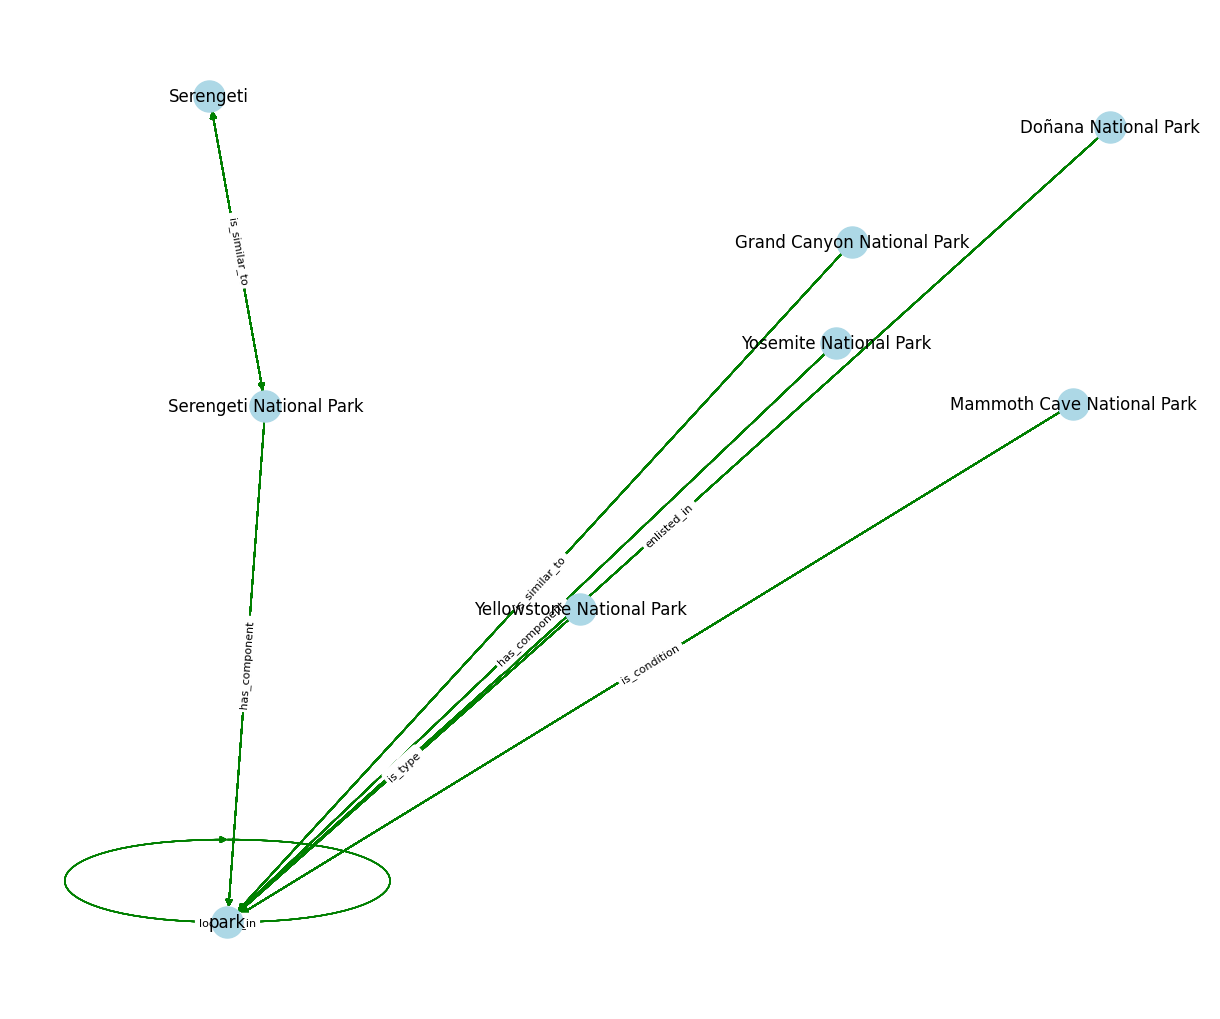

Query examples:
All nodes (entities):
('Grand Canyon National Park', {'labels': ['landmark_name']})
('park', {'labels': ['type']})
('Ajanta Caves', {'labels': ['landmark_name']})
('29', {'labels': ['number']})
('caves', {'labels': ['type']})
('Surtsey', {'labels': ['location']})
('5 June 1967', {'labels': ['date']})
('Yellowstone National Park', {'labels': ['landmark_name']})
('Yosemite National Park', {'labels': ['landmark_name']})
('Doñana National Park', {'labels': ['landmark_name']})
('Serengeti National Park', {'labels': ['landmark_name']})
('Serengeti', {'labels': ['landmark_name']})
('Mammoth Cave National Park', {'labels': ['landmark_name']})
('Cologne Cathedral', {'labels': ['landmark_name']})
('Germany', {'labels': ['location']})
('Kakadu National Park', {'labels': ['landmark_name']})
('Purnululu National Park', {'labels': ['landmark_name']})
('Derwent Valley Trust', {'labels': ['landmark_name']})
('Derwent Valley Mills World Heritage Site', {'labels': ['landmark_name']})
('D

In [35]:
from knowledge_graph import knowledgeGraph
graph = knowledgeGraph()

if COMPONENT == 1:
    if COMPONENT_1_SUBSET == "titles":
        save_path = "unesco_titles_knowledge_graph.png"
    else:
        save_path = "unesco_pages_knowledge_graph.png"
else:
    save_path = "technical_knowledge_graph.png"

graph.draw_graph(all_relations=REL_TRIPLETS, all_data=NER_ENTS, store_graph=True, subset = (3,34), save_path=save_path)

In [ ]:
#export knowledge graph to json
if COMPONENT==1:
    save_path="unesco_titles_knowledge_graph.json"
else:
    save_path="technical_knowledge_graph.json"
graph.export_json(all_relations=REL_TRIPLETS, all_data=NER_ENTS, save_path=save_path)